**Imports**


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import os
import zipfile
import random 
tfds.disable_progress_bar() 


Data set


In [ ]:
!git clone https://Jacob_Boesch@bitbucket.org/Jacob_Boesch/flower_classifier.git

Cloning into 'flower_classifier'...
remote: Counting objects: 4, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (4/4), done.


In [ ]:
path = '/content/flower_classifier'
data_dir = os.path.join(path)
zip_file = zipfile.ZipFile(data_dir + "/flower_data.zip", 'r')
zip_file.extractall('/tmp/images')
zip_file.close()

In [ ]:
import json 
label_map_file__path = '/tmp/images/flower_data/cat_to_name.json'

with open(label_map_file__path, 'rt') as label_file:
  label_map = json.load(label_file)


In [ ]:
train_data_dir = os.path.join('/tmp/images/flower_data/train')
validation_data_dir = os.path.join('/tmp/images/flower_data/valid')

In [ ]:
def get_sub_folder_names(base_dir):
  sub_folders = os.listdir(base_dir)
  for folder in sub_folders:
    if(os.path.isdir(base_dir +"/" + folder) == False):
      sub_folders.remove(folder)
  return sub_folders

In [ ]:
class_labels =  sorted(get_sub_folder_names(train_data_dir)) # sort list because the labels weren't in the same position as the train folder
print(class_labels) 
num_classes = len(class_labels)
print(num_classes)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
102


In [ ]:
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE = 224 # using 224 x 224 because that's what the pretrained mobile net model uses 
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # use a 224 x 224 image with rgb for the color data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = True
) 

train_generator = train_datagen.flow_from_directory(
        train_data_dir, 
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True
)

Found 818 images belonging to 102 classes.
Found 6552 images belonging to 102 classes.


In [ ]:

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 152

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 542,822
Non-trainable params: 1,845,824
_________________________________________________________________


In [ ]:
 from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
 callbacks = [EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001), 
           ModelCheckpoint(filepath='flower_classifier_weights.h5', save_best_only=True)]


In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1, callbacks=callbacks)

Epoch 1/10
205/205 [==============================] - 41s 199ms/step - loss: 2.9644 - accuracy: 0.3897 - val_loss: 1.9105 - val_accuracy: 0.5648 - lr: 0.0010
Epoch 2/10
205/205 [==============================] - 40s 193ms/step - loss: 1.2502 - accuracy: 0.7845 - val_loss: 1.1704 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 3/10
205/205 [==============================] - 40s 194ms/step - loss: 0.7891 - accuracy: 0.8724 - val_loss: 0.8390 - val_accuracy: 0.8093 - lr: 0.0010
Epoch 4/10
205/205 [==============================] - 39s 192ms/step - loss: 0.5785 - accuracy: 0.9113 - val_loss: 0.6851 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 5/10
205/205 [==============================] - 39s 191ms/step - loss: 0.4543 - accuracy: 0.9306 - val_loss: 0.5940 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 6/10
205/205 [==============================] - 39s 191ms/step - loss: 0.3739 - accuracy: 0.9463 - val_loss: 0.5275 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/10
205/205 [==============================] 

<Figure size 432x288 with 0 Axes>

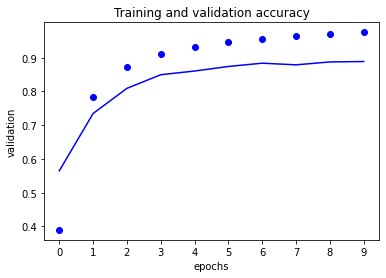

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.xlabel("epochs")
plt.ylabel("validation")
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0,1, .1))
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img) 
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=512)
  index = np.argmax(classes)
  print("The image is: " + class_labels[index])

Saving the-formosa-southern-indica-azalea-produces-larg-828x550.jpeg to the-formosa-southern-indica-azalea-produces-larg-828x550.jpeg
The image is: 30


### Save the labels to a file


In [ ]:
import random
import re
from keras.preprocessing import image

pattern = re.compile('.*\.jpg')

test_data = []
for label in class_labels:
  labeled_dir = os.path.join(validation_data_dir + "/", label)
  list_of_images = os.listdir(labeled_dir)
  random.shuffle(list_of_images)
  image_name = list_of_images[0]
  current_image_path = os.path.join(labeled_dir, image_name)
  img = image.load_img(current_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  image_data = image.img_to_array(img) 
  image_data = image_data / 255.0
  image_data = np.expand_dims(image_data, axis=0)
  test_data.append((image_data, label))
  

In [ ]:
with open("labels.txt", 'wt') as labels_file:
  for label in class_labels:
    labels_file.write(label_map[label] + "\n")

### Export the model to tflite

In [ ]:
flowers_saved_model = 'flowers_saved_model'
tf.saved_model.save(model, flowers_saved_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: flowers_saved_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(flowers_saved_model)

tflite_model = converter.convert() 
tflite_model_file = 'flower_model.tflite'

with open(tflite_model_file, 'wb') as file:
  file.write(tflite_model)


### Test the TFLite Model Using the Python Interpreter

In [ ]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(input_index)
print(output_index)
# Gather results for the randomly sampled test images
predictions = []
correct_count = 0
test_labels, test_imgs = [], []
for img, label in tqdm(test_data):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)
    if(class_labels[np.argmax(prediction)] == label):
      correct_count += 1
    
    predictions.append(prediction)
    
    test_labels.append(label)
    test_imgs.append(img)
print(correct_count / len(test_data))

  5%|▍         | 5/102 [00:00<00:02, 45.53it/s]

0
178


100%|██████████| 102/102 [00:01<00:00, 52.16it/s]

0.8333333333333334


In [ ]:
# visulize the results make sure they work using the tensorflow lite interpreter. 
# this part of the code came from the tensorflow lite course on coursera.
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if class_labels[predicted_label] == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                         100*np.max(predictions_array),
                                         class_labels[i]), color=color)


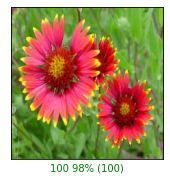

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:101, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

### Download the tflite file

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optional Download Test Images

In [ ]:
!mkdir -p test_images

from PIL import Image

for index, (image, label) in enumerate(test_data):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(label_map[label], index))

!ls test_images
!zip -qq flower_test_images.zip -r test_images/

'alpine sea holly_31.jpg'	    'king protea_7.jpg'
 anthurium_81.jpg		    'lenten rose_37.jpg'
 artichoke_24.jpg		     lotus_78.jpg
 azalea_72.jpg			    'love in the mist_29.jpg'
'ball moss_95.jpg'		     magnolia_88.jpg
'balloon flower_13.jpg'		     mallow_99.jpg
'barbeton daisy_38.jpg'		     marigold_44.jpg
'bearded iris_67.jpg'		    'mexican aster_30.jpg'
'bee balm_94.jpg'		    'mexican petunia_100.jpg'
'bird of paradise_80.jpg'	     monkshood_91.jpg
'bishop of llandaff_54.jpg'	    'moon orchid_69.jpg'
'blackberry lily_4.jpg'		    'morning glory_76.jpg'
'black-eyed susan_62.jpg'	    'orange dahlia_57.jpg'
'blanket flower_2.jpg'		     osteospermum_65.jpg
'bolero deep blue_42.jpg'	    'oxeye daisy_46.jpg'
 bougainvillea_97.jpg		    'passion flower_77.jpg'
 bromelia_101.jpg		     pelargonium_53.jpg
 buttercup_45.jpg		    'peruvian lily_12.jpg'
'californian poppy_64.jpg'	     petunia_49.jpg
 camellia_98.jpg		    'pincushion flower_17.jpg'
'canna lily_92.jpg'		    'pink primrose_0.jpg'
'ca

In [ ]:
from google.colab import files
try:
    files.download('flower_test_images.zip')
except:
  
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>